# Annotations to masks workflow

**Overview:** 

This includes tools to parse annotations from an item (slide) into masks to use in training and evaluating imaging algorithms. The basic functionality involves mapping annotation rectangles (potentially rotated) and polygons to regions-of-interest (ROIs) and making one mask per region of interest. This extends on some of the workflows described in Amgad et al, 2019:

__Mohamed Amgad, Habiba Elfandy, Hagar Hussein, ..., Jonathan Beezley, Deepak R Chittajallu, David Manthey, David A Gutman, Lee A D Cooper, Structured crowdsourcing enables convolutional segmentation of histology images, Bioinformatics, 2019, btz083__


This slide used as a test example:  

[TCGA-A2-A0YE-01Z-00-DX1](http://candygram.neurology.emory.edu:8080/histomicstk#?image=5d586d57bd4404c6b1f28640&bounds=53566%2C33193%2C68926%2C40593%2C0 )

The user uses a csv file like the one in 
```plugin_tests/test_files/sample_GTcodes.csv ```
to control pixel values assigned to mask, overlay order of various annotation groups, which groups are considered to be ROIs, etc.

**Why is this needed?**

The code handles the following complex situations:

- Multiple ROIs per item

- Rotated rectangular annotations and ROIs

- Polygonal ROIs

- Overlapping annotations

**Where to look?**

```
|_ histomicstk/
|   |
|   |_annotations_and_masks/
|      |_annotation_and_mask_utils.py 
|      |_annotations_to_masks_handler.py 
|
|_ plugin_tests/
    |
    |_annotations_and_masks/
    |  |_ annotation_and_mask_utils_test.py
    |  |_ annotations_to_masks_handler_test.py
    |
    |_test_files/
       |_sample_GTcodes.csv 
```

In [1]:
from __future__ import print_function

import os
import sys
CWD = os.getcwd()
sys.path.append(os.path.join(CWD, '..', '..'))

import girder_client
# from histomicstk.annotations_and_masks.annotation_and_mask_utils import (
from annotation_and_mask_utils import (
    get_image_from_htk_response, get_bboxes_from_slide_annotations, _get_idxs_for_all_rois)
# from histomicstk.annotations_and_masks.annotations_to_masks_handler import (
from annotations_to_masks_handler import (
    get_roi_mask, get_all_roi_masks_for_slide)

from imageio import imread
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 7, 7
titlesize = 16

## 1. Constants and prepwork

In [2]:
# APIURL = 'http://demo.kitware.com/histomicstk/api/v1/'
# SAMPLE_SLIDE_ID = '5bbdee92e629140048d01b5d'
APIURL = 'http://candygram.neurology.emory.edu:8080/api/v1/'
SAMPLE_SLIDE_ID = '5d586d57bd4404c6b1f28640'
GTCODE_PATH = os.path.join(CWD, '..', '..', 'plugin_tests','test_files', 'sample_GTcodes.csv')
MASK_SAVEPATH = os.path.join(CWD, '..', '..', 'roi_masks')

# connect to girder client
gc = girder_client.GirderClient(apiUrl=APIURL)
# gc.authenticate(interactive=True)
gc.authenticate(apiKey='kri19nTIGOkWH01TbzRqfohaaDWb6kPecRqGmemb')

# create folders if necessary
for folder in [MASK_SAVEPATH,]:
    try:
        os.mkdir(folder)
    except FileExistsError:
        pass

### Let's inspect the ground truth codes file

This contains the ground truth codes and information dataframe.
This is a dataframe that is indexed by the annotation group name and
has the following columns:

- ```group```: group name of annotation (string), eg. "mostly_tumor"
- ```overlay_order```: int, how early to place the annotation in the
    mask. Larger values means this annotation group is overlayed
    last and overwrites whatever overlaps it.
- ```GT_code```: int, desired ground truth code (in the mask)
    Pixels of this value belong to corresponding group (class)
- ```is_roi```: Flag for whether this group encodes an ROI
- ```is_background_class```: Flag, whether this group is the default
    fill value inside the ROI. For example, you may descide that
    any pixel inside the ROI is considered stroma.
    
**IMPORTANT NOTE:** 

Zero pixels have special meaning and do NOT encode specific ground truth class. Instead, they simply
mean 'Outside ROI' and should be IGNORED during model training or evaluation.

In [3]:
# read GTCodes file
GTCodes = read_csv(GTCODE_PATH)
GTCodes.index = GTCodes.loc[:, 'group']

In [4]:
GTCodes.head()

,group,overlay_order,GT_code,is_roi,is_background_class,color,comments
group,,,,,,,
roi,roi,0,255,1,0,"rgb(255,0,0)",NaN
evaluation_roi,evaluation_roi,0,254,1,0,"rgb(255,0,0)",NaN
mostly_tumor,mostly_tumor,1,1,0,0,"rgb(255,0,0)",core class
mostly_stroma,mostly_stroma,2,2,0,1,"rgb(255,125,0)",core class
mostly_lymphocytic_infiltrate,mostly_lymphocytic_infiltrate,1,3,0,0,"rgb(0,0,255)",core class


## 2. Get all ROIs for a slide

### This is the core method you'll want to use

In [5]:
print(get_all_roi_masks_for_slide.__doc__)


    Parse annotations and saves ground truth masks for ALL ROIs.

    Get all ROIs in a single slide. This is a wrapper around get_roi_mask()
    which should be referred to for implementation details.

    Parameters
    -----------
    gc : object
        girder client object to make requests, for example:
        gc = girder_client.GirderClient(apiUrl = APIURL)
        gc.authenticate(interactive=True)
    slide_id : str
        girder id for item (slide)
    GTCODE_PATH : str
        path to the ground truth codes and information
        csv file. Refer to the docstring of get_roi_mask() for more info.
    MASK_SAVEPATH : str
        path to directory to save ROI masks
    slide_name (optional) : str
        If not given, it's inferred using a server request using girder client.
    verbose (optional) : bool
        Print progress to screen?
    monitorPrefix (optional) : str
        text to prepend to printed statements
    get_roi_mask_kwargs : dict
        extra kwargs for get_

The parameter ```get_roi_mask_kwargs``` is a dictionary of ```kwargs``` that is passed on to ```get_roi_mask()```. Watchout for the following parameters:

- ```crop_to_roi``` - flag of whether to crop polygons to roi (prevent 'overflow' beyond roi edge)

- ```use_shapely``` - flag of whether to precisely determine whether an element
    belongs to an ROI using shapely polygons. Ever-so-slightly slower. If
    set to False, overlapping bounding box is used as a cheap but
    less precise indicator of inclusion.

In [6]:
savenames = get_all_roi_masks_for_slide(
    gc=gc, slide_id=SAMPLE_SLIDE_ID, GTCODE_PATH=GTCODE_PATH,
    MASK_SAVEPATH=MASK_SAVEPATH, verbose=True,
    get_roi_mask_kwargs={
        'iou_thresh': 0.0, 'crop_to_roi': True, 'use_shapely': True,
        'verbose': True},
)

: roi 1 of 3: Overlay level -1: Element 1 of 54: roi
: roi 1 of 3: Overlay level -1: Element 2 of 54: roi
: roi 1 of 3: Overlay level -1: Element 2 of 54: roi: OUSIDE ROI.
: roi 1 of 3: Overlay level 1: Element 3 of 54: mostly_tumor
: roi 1 of 3: Overlay level 1: Element 4 of 54: mostly_tumor
: roi 1 of 3: Overlay level 1: Element 4 of 54: mostly_tumor: OUSIDE ROI.
: roi 1 of 3: Overlay level 1: Element 5 of 54: mostly_lymphocytic_infiltrate
: roi 1 of 3: Overlay level 1: Element 6 of 54: mostly_tumor
: roi 1 of 3: Overlay level 1: Element 7 of 54: mostly_tumor
: roi 1 of 3: Overlay level 1: Element 8 of 54: mostly_lymphocytic_infiltrate
: roi 1 of 3: Overlay level 1: Element 9 of 54: mostly_lymphocytic_infiltrate
: roi 1 of 3: Overlay level 1: Element 10 of 54: mostly_lymphocytic_infiltrate
: roi 1 of 3: Overlay level 1: Element 11 of 54: mostly_tumor
: roi 1 of 3: Overlay level 1: Element 12 of 54: mostly_lymphocytic_infiltrate
: roi 1 of 3: Overlay level 1: Element 13 of 54: mostly_

### Let's visualize the ROIs created

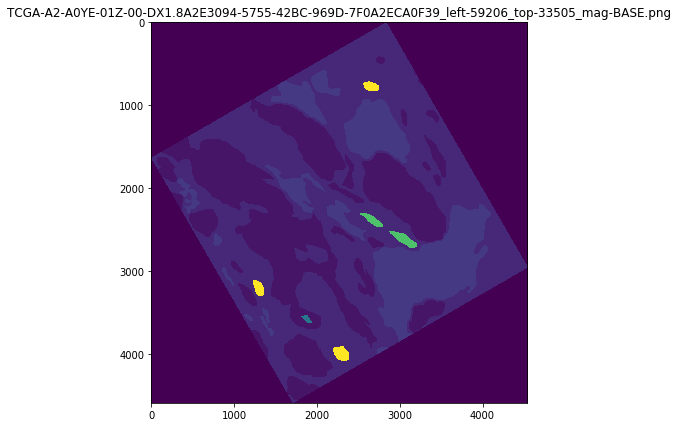

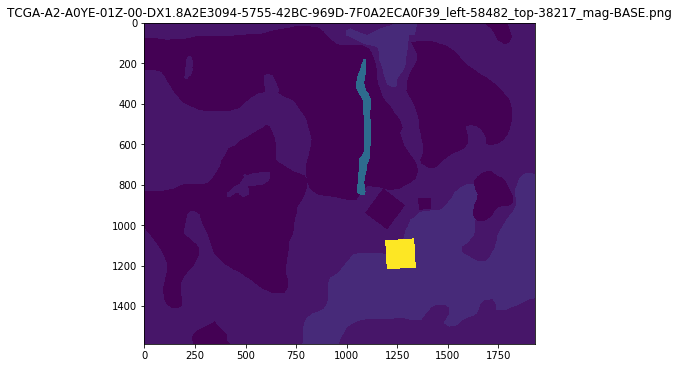

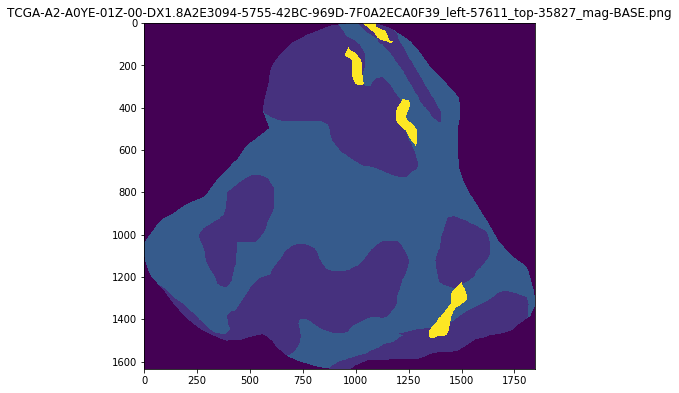

In [7]:
for savename in savenames:
    ROI = imread(savename)
    plt.figure(figsize=(7,7))
    plt.imshow(ROI)
    plt.title(os.path.split(savename)[1])
    plt.show()

### Now let's repeat the process without cropping to the ROI boundary

In [8]:
savenames = get_all_roi_masks_for_slide(
    gc=gc, slide_id=SAMPLE_SLIDE_ID, GTCODE_PATH=GTCODE_PATH,
    MASK_SAVEPATH=MASK_SAVEPATH, verbose=True,
    get_roi_mask_kwargs={
        'iou_thresh': 0.0, 'crop_to_roi': False, 'use_shapely': True,
        'verbose': False},
)

: roi 1 of 3: Saving C:\Users\tageldim\Desktop\HistomicsTK\histomicstk\annotations_and_masks\..\..\roi_masks\TCGA-A2-A0YE-01Z-00-DX1.8A2E3094-5755-42BC-969D-7F0A2ECA0F39_left-59206_top-33505_mag-BASE.png

: roi 2 of 3: Saving C:\Users\tageldim\Desktop\HistomicsTK\histomicstk\annotations_and_masks\..\..\roi_masks\TCGA-A2-A0YE-01Z-00-DX1.8A2E3094-5755-42BC-969D-7F0A2ECA0F39_left-58294_top-37917_mag-BASE.png

: roi 3 of 3: Saving C:\Users\tageldim\Desktop\HistomicsTK\histomicstk\annotations_and_masks\..\..\roi_masks\TCGA-A2-A0YE-01Z-00-DX1.8A2E3094-5755-42BC-969D-7F0A2ECA0F39_left-56743_top-35575_mag-BASE.png



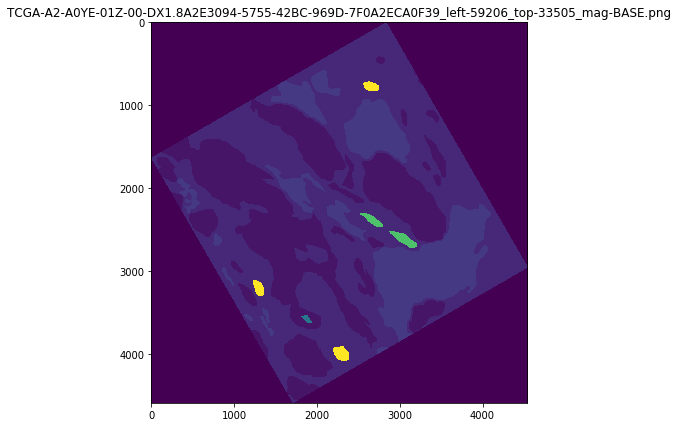

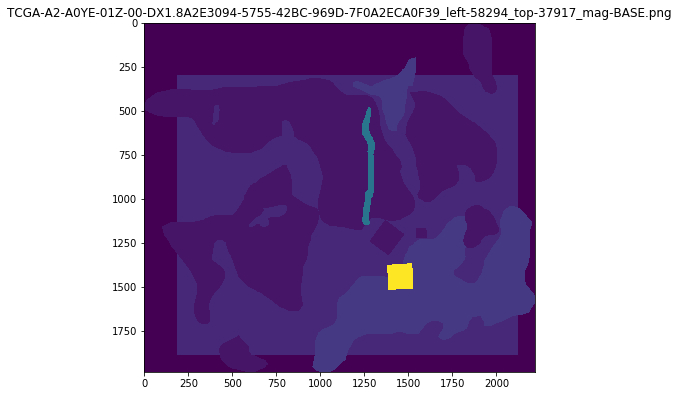

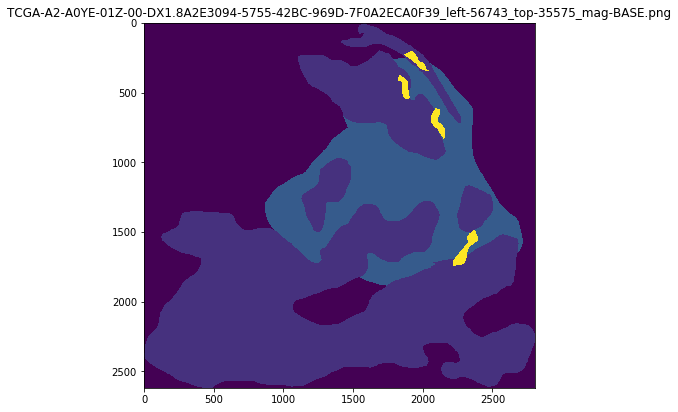

In [9]:
# let's visualize the ROIs
for savename in savenames:
    ROI = imread(savename)
    plt.figure(figsize=(7,7))
    plt.imshow(ROI)
    plt.title(os.path.split(savename)[1])
    plt.show()

## 3. [EXTRA] - Explore some of the inner workings

### Core method being called to get a specific ROI from a slide

In [10]:
print(get_roi_mask.__doc__)


    Parse annotations and gets a ground truth mask for a single ROI.

    This will look at all slide annotations and get ones that
    overlap with the region of interest (ROI) and assigns them to mask.

    Parameters
    -----------
    slide_annotations : list of dicts
        response from server request
        eg. slide_annotations = gc.get('/annotation/item/' + SLIDE_ID)
    element_infos : pandas DataFrame.
        The columns annidx and elementidx
        encode the dict index of annotation document and element,
        respectively, in the original slide_annotations list of dictionaries.
        This can be obain by get_bboxes_from_slide_annotations() method, eg.
        element_infos  = get_bboxes_from_slide_annotations(slide_annotations)
    GTCodes_df : pandas Dataframe
        the ground truth codes and information dataframe.
        This is a dataframe that is indexed by the annotation group name and
        has the following columns:
        - group: group name of ann

### Get slide annotations and bounding boxes for all elements

In [11]:
slide_annotations = gc.get('/annotation/item/' + SAMPLE_SLIDE_ID)
element_infos = get_bboxes_from_slide_annotations(slide_annotations)

In [12]:
element_infos.head()

,annidx,elementidx,type,group,xmin,xmax,ymin,ymax,bbox_area
0,0.0,0.0,rectangle,roi,59206.0,63749.0,33505.0,38100.0,20875085.0
1,1.0,0.0,polyline,blood_vessel,61403.0,61590.0,37411.0,37587.0,32912.0
2,1.0,1.0,polyline,blood_vessel,60436.0,60570.0,36612.0,36811.0,26666.0
3,1.0,2.0,polyline,blood_vessel,61763.0,61950.0,34218.0,34342.0,23188.0
4,2.0,0.0,polyline,mostly_lymphocytic_infiltrate,61875.0,63301.0,35695.0,37360.0,2374290.0


### Now get a specific ROI

In [13]:
# get indices of rois relative to the element_infos dataframe
idxs_for_all_rois = _get_idxs_for_all_rois(
    GTCodes=GTCodes, element_infos=element_infos)

In [14]:
# get roi mask and information
ROI, roiinfo = get_roi_mask(
    slide_annotations=slide_annotations, element_infos=element_infos,
    GTCodes_df=GTCodes.copy(),
    idx_for_roi=idxs_for_all_rois[0],  # <- let's focus on first ROI,
    iou_thresh=0.0, roiinfo=None, crop_to_roi=True, use_shapely=True,
    verbose=False, monitorPrefix="roi 1")

In [15]:
roiinfo

{'BBOX_HEIGHT': 4820,
 'BBOX_WIDTH': 7006,
 'XMAX': 66212,
 'XMIN': 59206,
 'YMAX': 38325,
 'YMIN': 33505}

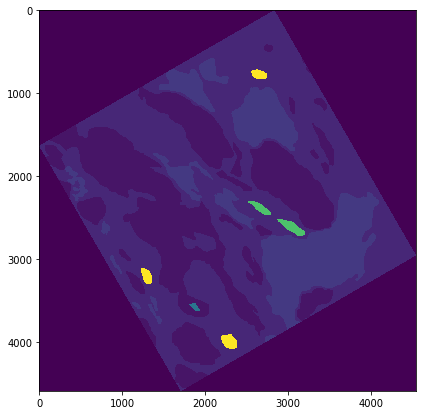

In [16]:
plt.figure(figsize=(7,7))
plt.imshow(ROI)
plt.show()